In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, generic_filter
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
# Function to count and locate bad pixels
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))
    threshold = local_mean + threshold_factor * local_std
    bad_pixel_mask = image_data > threshold
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)
    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

# Calculate spatial noise using a window method
def calculate_spatial_noise_window(image_data, window_size):
    spatial_noise = generic_filter(image_data, np.std, size=window_size)
    return spatial_noise

# Calculate temporal noise
def calculate_temporal_noise(image_stack):
    temporal_noise = np.std(image_stack, axis=0)
    return temporal_noise

def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    hdul.close()
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)
    spatial_noise = calculate_spatial_noise_window(image_data, window_size)
    return image_data, bad_pixel_mask, spatial_noise

def process_images(fits_filenames, threshold_factor, neighborhood_size, window_size):
    image_stack = []
    spatial_noise_stack = []  # To store spatial noise of each image
    bad_pixel_mask_stack = []
    
    for fits_filename in fits_filenames:
        image_data, bad_pixel_mask, spatial_noise = process_image(fits_filename, threshold_factor, neighborhood_size, window_size)
        image_stack.append(image_data)
        spatial_noise_stack.append(spatial_noise)
        bad_pixel_mask_stack.append(bad_pixel_mask)

    # Combine into numpy arrays for further processing
    image_stack = np.array(image_stack)
    spatial_noise_stack = np.array(spatial_noise_stack)
    bad_pixel_mask_stack = np.array(bad_pixel_mask_stack)
    
    # Calculate temporal noise
    temporal_noise = calculate_temporal_noise(image_stack)
    
    return image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack

# Best region within the full frame for fast scan mode (window across columns)
def find_best_region_in_frame_fast_scan(image_data, bad_pixel_mask, spatial_noise, temporal_noise, region_height=36, region_width=159):
    rows, cols = image_data.shape[:2]

    min_bad_pixels = float('inf')
    min_combined_noise = float('inf')
    best_region_start_row = 0
    best_region_start_col = 0
    
    # Search within the full frame
    for row in range(rows - region_height + 1):
        for col in range(cols - region_width + 1):  # Limit search within the full frame
            region_bad_pixels = np.sum(bad_pixel_mask[row:row+region_height, col:col+region_width])
            region_spatial_noise = np.mean(spatial_noise[row:row+region_height, col:col+region_width])
            region_temporal_noise = np.mean(temporal_noise[row:row+region_height, col:col+region_width])
            combined_noise = region_spatial_noise + region_temporal_noise
            
            if (region_bad_pixels < min_bad_pixels) or (region_bad_pixels == min_bad_pixels and combined_noise < min_combined_noise):
                min_bad_pixels = region_bad_pixels
                min_combined_noise = combined_noise
                best_region_start_row = row
                best_region_start_col = col
    
    return best_region_start_row, best_region_start_col

def visualize_best_region_on_full_frame(image_data, best_region_start_row, best_region_start_col, region_height=36, region_width=159):
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')

    # Draw a rectangle showing the best region
    rect = plt.Rectangle((best_region_start_col, best_region_start_row), region_width, region_height,
                         edgecolor='red', facecolor='none', linewidth=2, label='Best Region')
    plt.gca().add_patch(rect)
    
    plt.title('Best Region on Full Detector Frame')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.legend()
    plt.show()
    
def visualize_zoomed_region(image_data, best_region_start_row, best_region_start_col, region_height=36, region_width=159):
    # Extract the region of interest (ROI) from the image
    roi = image_data[best_region_start_row:best_region_start_row+region_height,
                     best_region_start_col:best_region_start_col+region_width]
    
    plt.figure(figsize=(6, 4))
    plt.imshow(roi, cmap='gray', origin='lower')
    plt.title('Zoomed-in View of Selected Region')
    plt.xlabel('X Pixels (relative)')
    plt.ylabel('Y Pixels (relative)')
    plt.colorbar(label='Pixel Values')
    plt.show()

In [3]:
fits_filenames = [f'12r_5c_1g_1res_1read/H2RG_Slow_FullWin_20241126_{str(i).zfill(6)}.fits' 
                  for i in range(1, 12)]
threshold_factor = 6
neighborhood_size = 5
window_size = 10  

image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack = process_images(
    fits_filenames, threshold_factor, neighborhood_size, window_size)

In [4]:
# Find the best region within the full frame for fast scan mode (window across columns)
best_region_start_row, best_region_start_col = find_best_region_in_frame_fast_scan(
    image_stack[0], 
    bad_pixel_mask_stack[0],  # Use bad_pixel_mask for the first image
    spatial_noise_stack[0], 
    temporal_noise,
    region_height=36,
    region_width=159
)

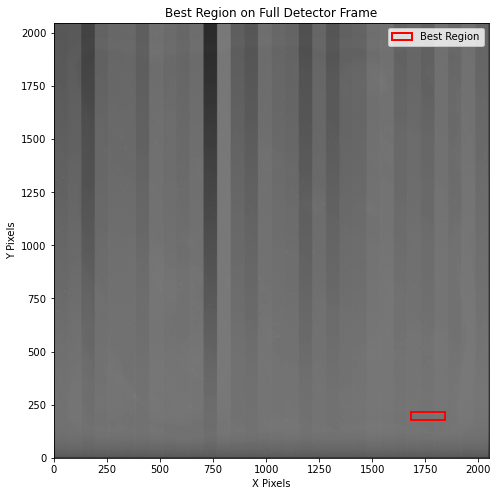

Best region coordinates: Start Row = 177, Start Column = 1684
Region Dimensions: Width = 159, Height = 36


In [5]:
region_height=36
region_width=159

# Visualize the best region within the frame
visualize_best_region_on_full_frame(image_stack[0], best_region_start_row, best_region_start_col, region_height=36, region_width=159)
# Print the coordinates of the best region
print(f"Best region coordinates: Start Row = {best_region_start_row}, Start Column = {best_region_start_col}")
print(f"Region Dimensions: Width = {region_width}, Height = {region_height}")

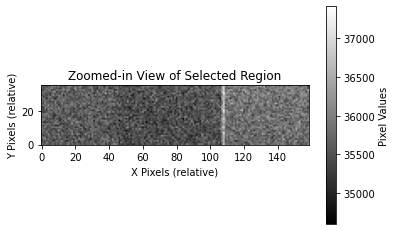

In [6]:
# After calling visualize_best_region_on_full_frame, call the zoomed region function:
visualize_zoomed_region(image_stack[0], best_region_start_row, best_region_start_col, region_height=36, region_width=159)

In [13]:
def visualize_best_region_on_full_frame(image_data, best_region_start_row, best_region_start_col, region_height=36, region_width=159):
    plt.figure(figsize=(12, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')

    # Draw a rectangle showing the best region
    rect = plt.Rectangle((best_region_start_col, best_region_start_row), region_width, region_height,
                         edgecolor='red', facecolor='none', linewidth=2, label='Best Region')
    plt.gca().add_patch(rect)
    
    plt.title('Best Horizontal Region on Full Detector Frame', fontsize=18)
    plt.xlabel('X Pixels', fontsize=16)
    plt.ylabel('Y Pixels', fontsize=16)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig('full_frame_fast_R400.png', dpi=300, bbox_inches='tight')
    plt.show()
    
def visualize_zoomed_region(image_data, best_region_start_row, best_region_start_col, region_height=36, region_width=159):
    # Extract the region of interest (ROI) from the image
    roi = image_data[best_region_start_row:best_region_start_row+region_height,
                     best_region_start_col:best_region_start_col+region_width]
    
    plt.figure(figsize=(6, 4))
    plt.imshow(roi, cmap='gray', origin='lower')
#     plt.title('Zoomed-in View of Selected Region')
#     plt.xlabel('X Pixels (relative)')
#     plt.ylabel('Y Pixels (relative)')
#     plt.colorbar(label='Pixel Values')
    plt.savefig('zoomin_fast_R400.png', dpi=300, bbox_inches='tight')
    plt.show()

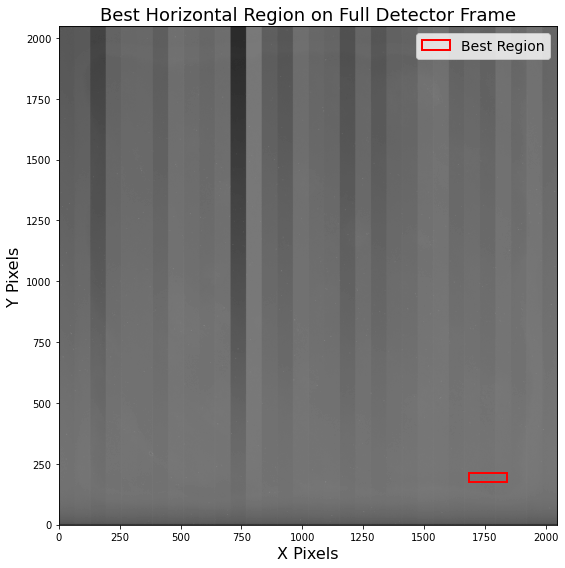

In [8]:
visualize_best_region_on_full_frame(image_stack[0], best_region_start_row, best_region_start_col, region_height=36, region_width=159)

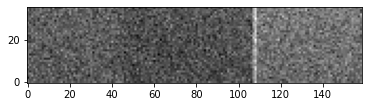

In [14]:
# After calling visualize_best_region_on_full_frame, call the zoomed region function:
visualize_zoomed_region(image_stack[0], best_region_start_row, best_region_start_col, region_height=36, region_width=159)